In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re
import time

In [2]:
def scroll(driver, timeout, loops):
    scroll_pause_time = timeout

    last_height = driver.execute_script("return document.body.scrollHeight")
    num = 0
    
    while True and num < loops:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        num = num + 1
        time.sleep(scroll_pause_time)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

In [3]:
url = 'https://www.vivino.com/explore?e=eJzLLbI1VMvNzLM1UMtNrLA1NTBQS660dXFVS7Z1DQ1SKwDKpqfZliUWZaaWJOao5SfZFiWWZOalF8cn55fmlajl26akFierlZdEx9oaAQC-MhnG'
product_names = []
profile = webdriver.FirefoxProfile()
profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
options = Options()
options.headless = True
browser = webdriver.Firefox(options=options)
options.add_argument("start-maximized")
options.add_argument('disable-infobars')

def scrape():
    browser.get(url)
    loops = 200
    timeout = 3
    scroll(browser, timeout, loops)

    titles = browser.find_elements_by_class_name('vintageTitle__wine--U7t9G')
    prices = browser.find_elements_by_xpath("(//*[contains(@class, 'addToCartButton__price')])")
    ratings = browser.find_elements_by_class_name('vivinoRating__averageValue--3Navj')
    countries = browser.find_elements_by_xpath('//a[contains(@href, "/explore?country_code")]')
    
    for title, price, rating, country in zip(titles, prices, ratings, countries):
        with open('vinDataWhite.csv', 'a', encoding='UTF8') as f:
            writer = csv.writer(f)
            date = 9999
            line = re.findall(r'\d+', title.text)
        
            if(len(line)>0):
                for l in line:
                    if(len(str(l)) == 4):
                        date = l
                    
            data = [title.text, date, price.text.split("\n", 1)[0], rating.text, country.text]
            writer.writerow(data)
                                

In [4]:
#scrape()

In [5]:
df = pd.read_csv('vinData.csv')
print(len(df))
df.head()

3754


,Name,Year,Price,Rating,Reviews,Country
0,Edizione Cinque Autoctoni,9999.0,149.00,4.3,57775.0,Italy
1,Malbec 2016,2016.0,69.95,3.6,16818.0,Argentina
2,Malbec 2018,2018.0,59.95,3.8,16779.0,Argentina
3,Malbec 2016,2016.0,129.95,4.1,16138.0,Argentina
4,Cabernet Sauvignon 2016,2016.0,1245.00,4.6,13945.0,United States


In [6]:
yearMask = df['Year'] < 2022
dfClean = df[yearMask]
dfClean.head()

,Name,Year,Price,Rating,Reviews,Country
1,Malbec 2016,2016.0,69.95,3.6,16818.0,Argentina
2,Malbec 2018,2018.0,59.95,3.8,16779.0,Argentina
3,Malbec 2016,2016.0,129.95,4.1,16138.0,Argentina
4,Cabernet Sauvignon 2016,2016.0,1245.00,4.6,13945.0,United States
5,Malbec 2013,2013.0,99.95,3.9,13271.0,Argentina




## SAMMENHÆNG I DATAENS COLUMNS
Vi ville undersøge om der er en correlation mellem f.eks. år og pris, pris og rating, og så videre.

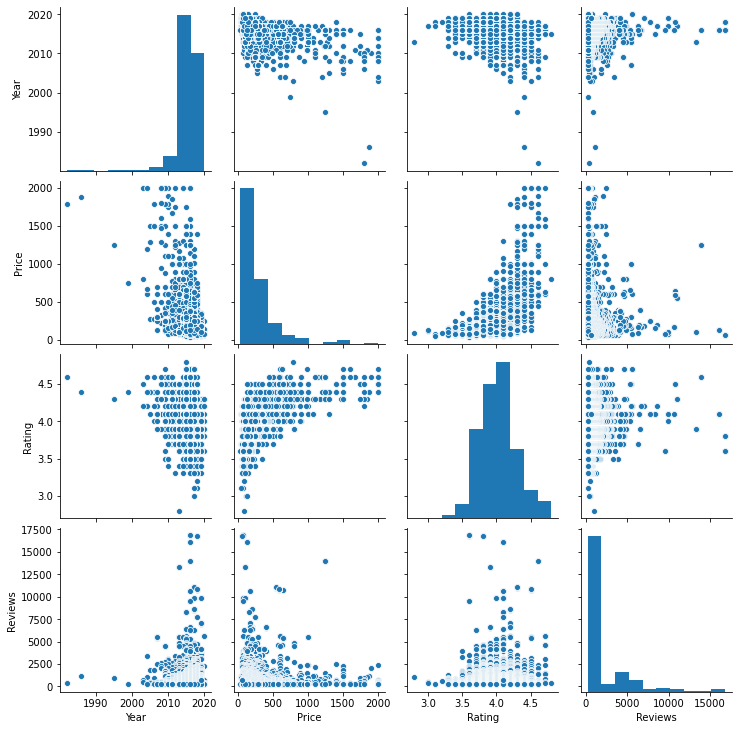

In [7]:
import seaborn as sb

sb.pairplot(dfClean)

In [8]:
dfClean.corr()

,Year,Price,Rating,Reviews
Year,1.000000,-0.426985,-0.196911,0.038382
Price,-0.426985,1.000000,0.634099,-0.003722
Rating,-0.196911,0.634099,1.000000,0.150601
Reviews,0.038382,-0.003722,0.150601,1.000000


In [9]:
#dfLarge = pd.read_csv('vinDataLarge.csv')
#yearMask = dfLarge['Year'] < 2022
#dfLargeClean = dfLarge[yearMask]

#dfLargeClean.corr()

0.6340993245490931


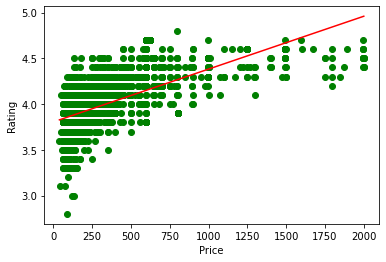

In [10]:
x = dfClean['Price']
y = dfClean['Rating']

plt.scatter(x, y, color='g')


plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
correlation = x.corr(y)
plt.xlabel('Price')
plt.ylabel('Rating')
print(correlation)

-0.19691099827976327


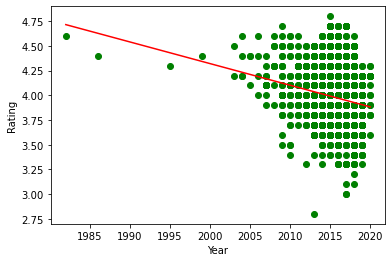

In [11]:
x = dfClean['Year']
y = dfClean['Rating']
plt.scatter(x, y, color='g')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
correlation = x.corr(y)
plt.xlabel('Year')
plt.ylabel('Rating')
print(correlation)

Vi kan se at desto større databasen er, desto stærkere er correlationen mellem pris og rating. Ville der være årsag til at scrape endnu mere?

In [12]:
print(len(dfClean))
for size in range(300, 3200, 200):
    print("Correlation ved størrelse " + str(size) + ": " + str(dfClean['Year'][0:size].corr(dfClean['Rating'][0:size])))

3723
Correlation ved størrelse 300: -0.2630798403260409
Correlation ved størrelse 500: -0.20867129158030726
Correlation ved størrelse 700: -0.15322350900882656
Correlation ved størrelse 900: -0.18200931898088302
Correlation ved størrelse 1100: -0.18544724161276194
Correlation ved størrelse 1300: -0.2027121313452922
Correlation ved størrelse 1500: -0.22509326086905834
Correlation ved størrelse 1700: -0.2405081417006017
Correlation ved størrelse 1900: -0.24218432265887038
Correlation ved størrelse 2100: -0.25813968943259
Correlation ved størrelse 2300: -0.25658840675289607
Correlation ved størrelse 2500: -0.2494570038926643
Correlation ved størrelse 2700: -0.24356665707937042
Correlation ved størrelse 2900: -0.23862145172212637
Correlation ved størrelse 3100: -0.23441250434903466


Videre undersøgning af hvor stærk correlationen er:

In [13]:
from sklearn.linear_model import LinearRegression
x = (dfClean['Price'].values).reshape(-1,1)
y = (dfClean['Rating'].values)
reg = LinearRegression().fit(x, y)

print("Sklearn LinearRegression score på korrelationen: " + str(reg.score(x, y))) 
print("Koefficienten: + " + str(reg.coef_))
print("Konstanten: " + str(reg.intercept_))

print(reg.predict([[450]]))
print("Vi kan forvente at en vin til prisen 450. har en rating på:"); print(0.00056345 * 450 + 3.81)


Sklearn LinearRegression score på korrelationen: 0.4020819533936151
Koefficienten: + [0.00057727]
Konstanten: 3.8051080538020505
[4.06487743]
Vi kan forvente at en vin til prisen 450. har en rating på:
4.0635525


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

dfTrain = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dfTrain

print(dfTrain[60:75])
print(r2_score(dfTrain['Actual'], dfTrain['Predicted']))

    Actual  Predicted
60     4.0   3.979472
61     4.0   3.953264
62     4.1   3.903122
63     4.1   3.920614
64     4.1   3.880355
65     3.7   3.854118
66     4.0   4.142170
67     4.6   4.967758
68     4.1   3.949766
69     4.4   4.066957
70     4.1   3.967257
71     3.8   3.868694
72     3.5   3.868140
73     4.6   4.530476
74     3.8   3.871638


0.3765234445000859

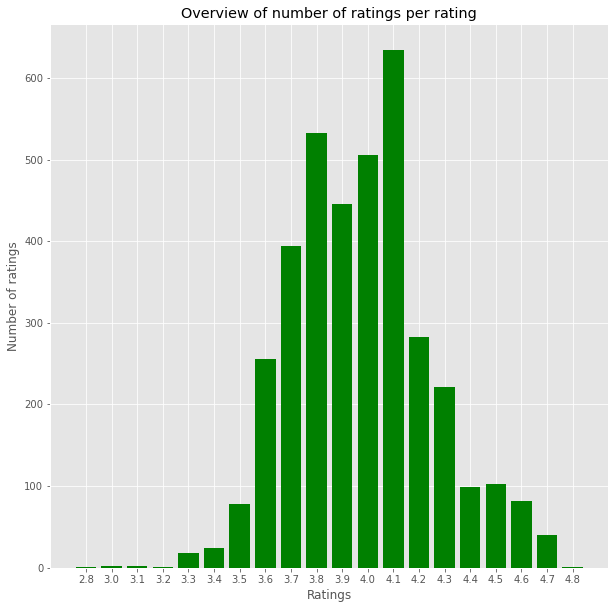

In [15]:
%matplotlib inline

dfratings = dfClean.Rating.unique()
ratings = dfratings.sort()

plotdata = pd.DataFrame(0, index=dfratings, columns=['Count'])

loop = 0
for r in dfratings: 
    for row in dfClean['Rating']:
        if(row == r):
            plotdata['Count'].iloc[loop] = plotdata['Count'].iloc[loop] + 1
    loop += 1
   
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))
x = plotdata.index
y = plotdata['Count']
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y, color='green')
plt.xlabel("Ratings")
plt.ylabel("Number of ratings")
plt.title("Overview of number of ratings per rating")

plt.xticks(x_pos, x)

plt.show()